In [3]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.ndimage.filters import gaussian_filter

Populating the interactive namespace from numpy and matplotlib


/home/hp/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/TestLapseData2d_151119-nmy2GFP-tagRfpPH-wt-04_w1LMM_488+488_LP_myTestCrop_bgrem.tif'
#filename = '/Users/jug/Dropbox/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
#filename = '/Users/jug/Repositories/GIT/BobSeg/data/MAX_LP320-06-08_Concat-51-100.tif'
filename = '/home/hp/git/BobSeg/data/4MyosinMembraneWholeEmbryo.tif'


stack = imread(filename)

segchannel = stack[:,0,:,:]
flowchannel = stack[:,1,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

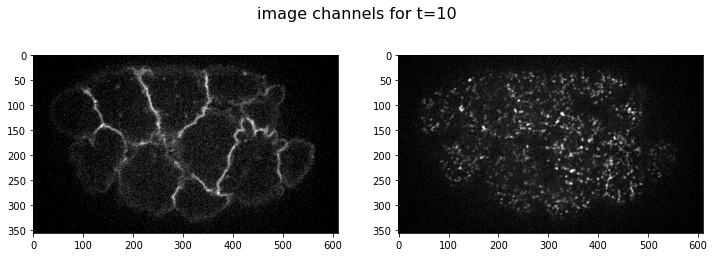

In [5]:
t=10
pylab.rcParams['figure.figsize'] = (12, 4)
fig = plt.figure()
fig.suptitle('image channels for t=%d'%t, fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(segchannel[t], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flowchannel[t], plt.get_cmap('gray'))

In [6]:
def compute_flow( flowchannel ):
    flows = [None] * len(flowchannel)
    prvs = flowchannel[0]
    for f in range(flowchannel.shape[0]):
        nxt = flowchannel[f]
        flow = cv2.calcOpticalFlowFarneback(prev=prvs,
                                            next=nxt,
                                            pyr_scale=0.5,
                                            levels=3,
                                            winsize=5,
                                            iterations=15,
                                            poly_n=5,
                                            poly_sigma=1.5,
                                            flags=1)
        flows[f] = flow
        prvs = nxt
        print '.',
    print ' ...done!'
    return flows

In [7]:
flows = compute_flow( flowchannel );

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  ...done!


In [8]:
flow_x = np.moveaxis(np.swapaxes(flows,0,3)[0],-1,0)
flow_y = np.moveaxis(np.swapaxes(flows,0,3)[1],-1,0)

In [62]:
avg_flow_x = np.average(flow_x[30:], axis=0)
avg_flow_y = np.average(flow_y[30:], axis=0)

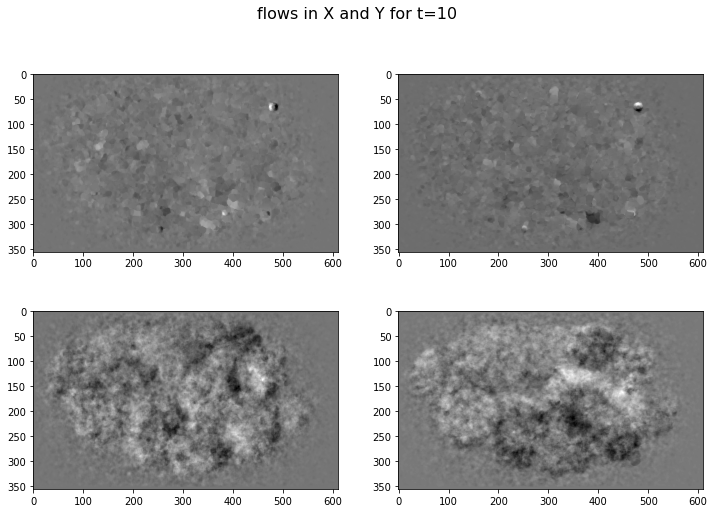

In [10]:
pylab.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure()
fig.suptitle('flows in X and Y for t=%d'%t, fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(flow_x[t], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(flow_y[t], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(avg_flow_x, plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(avg_flow_y, plt.get_cmap('gray'))

In [11]:
y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]

In [12]:
def plot_flow_arrows(flow_x, flow_y):
    pylab.rcParams['figure.figsize'] = (12, 7)
    fig = plt.figure()
    fig, ax = plt.subplots()

    ax.imshow(segchannel[t])#, plt.get_cmap('gray'))
    skip = (slice(None, None, 10), slice(None, None, 10))

    ax.quiver(x[skip],y[skip],flow_x[skip],-flow_y[skip], color='w')

In [13]:
def euclid(a, b):
    size_x, size_y = shape(a)[0], shape(a)[1]
    c = np.zeros((size_x, size_y))
    for i in range(size_x):
        for j in range(size_y):
            c[i][j] =  a[i][j]*a[i][j] + b[i][j]*b[i][j]
            c[i][j] = np.sqrt(c[i][j])
    return c

def normalise(X, Y):
    R = euclid(X, Y)
    size_x, size_y = shape(X)[0], shape(X)[1]
    eps = 0.000001
    norm_X = np.zeros((size_x, size_y))
    norm_Y = np.zeros((size_x, size_y))
    for i in range(size_x):
        for j in range(size_y):
            if R[i][j] <= eps and R[i][j] >= - eps:
                norm_X[i][j], norm_Y[i][j] = 0, 0
            else:
                norm_X[i][j], norm_Y[i][j] = X[i][j]/R[i][j], Y[i][j]/R[i][j]
    return norm_X, norm_Y

def normalise_0(X, Y):
    R = euclid(X, Y)
    return X/R, Y/R

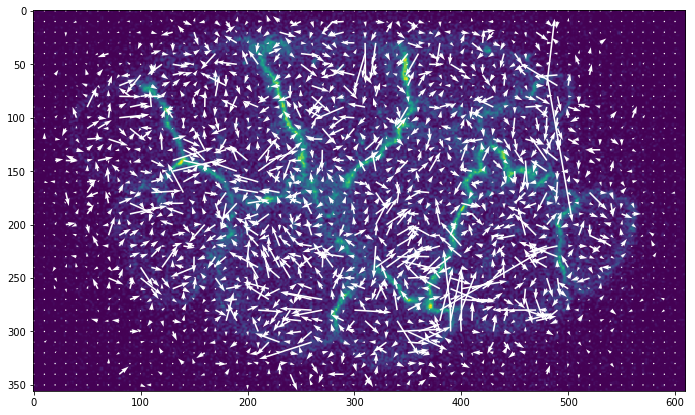

In [63]:
#flow at frame 't'
t=10
plot_flow_arrows(flow_x[t], flow_y[t])

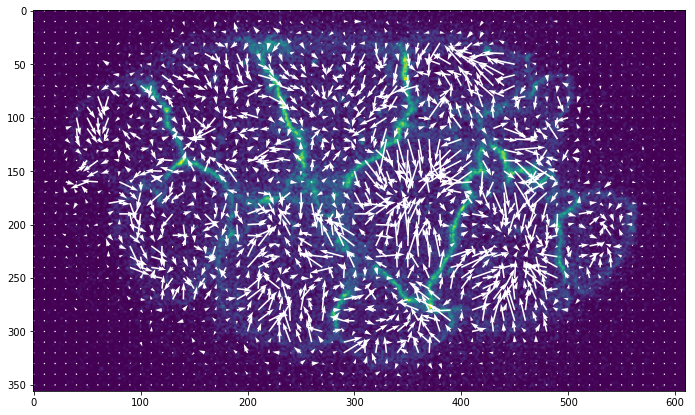

In [64]:
#avg flow from t:end here t=30
plot_flow_arrows(avg_flow_x, avg_flow_y)

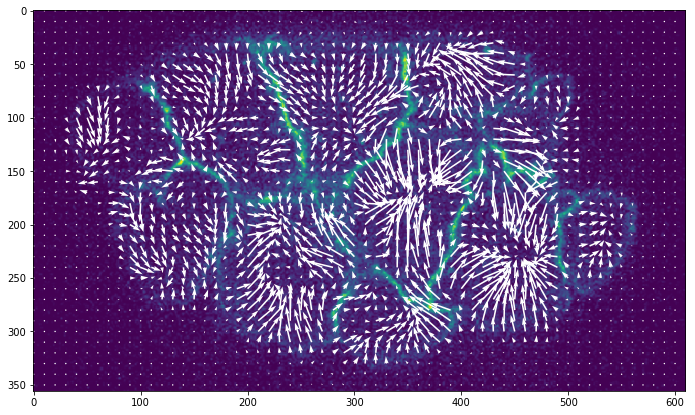

In [65]:
#smoothing the average flow
smooth_flow_x = gaussian_filter(avg_flow_x, sigma=7)
smooth_flow_y = gaussian_filter(avg_flow_y, sigma=7)
plot_flow_arrows(smooth_flow_x, smooth_flow_y)

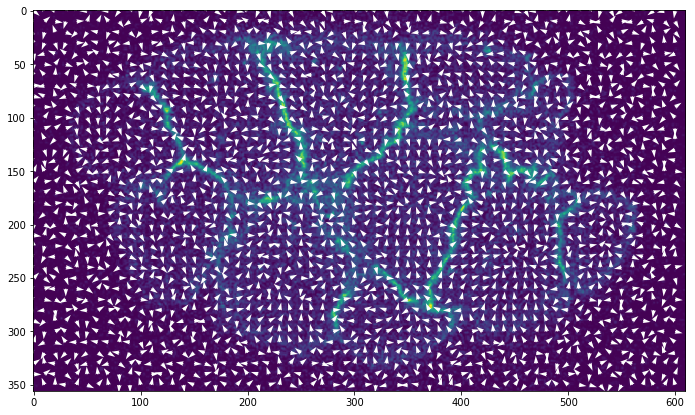

In [66]:
norm_flow_x, norm_flow_y = normalise(avg_flow_x, avg_flow_y)
plot_flow_arrows(norm_flow_x, norm_flow_y)

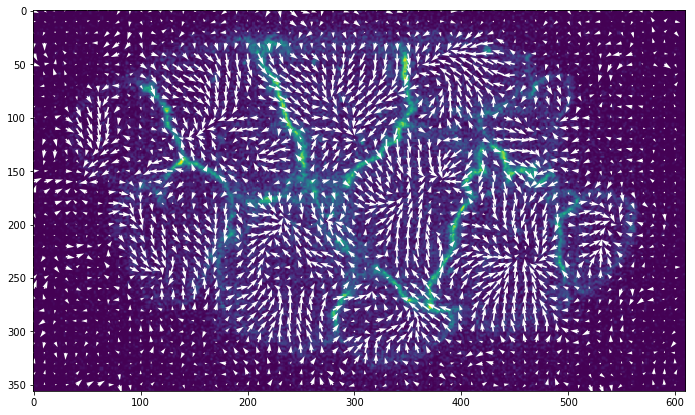

In [67]:
#smoothing out the normalised flow
smooth_norm_x = gaussian_filter(norm_flow_x, sigma=7)
smooth_norm_y = gaussian_filter(norm_flow_y, sigma=7)
plot_flow_arrows(smooth_norm_x, smooth_norm_y)

In [22]:
def divergence(X, Y):
    #compute divergence
    div = np.gradient(X, axis=1) + np.gradient(Y, axis=0)
    return div

In [23]:
def compute_convergence_points(div, epsilon):
    #set threshold
    threshold = np.min(div) + epsilon
    size_x, size_y = shape(div)[0], shape(div)[1]
    flg = numpy.full((size_x, size_y), False, dtype=bool)
    points = []  
    zero_div = []
    for i in range(size_x):
        for j in range(size_y):
            if div[i][j] == 0:
                flg[i][j] = 1
                zero_div.append((j,i))
                points.append((j,i))
            elif div[i][j] <= threshold:
                flg[i][j] = 1
                points.append((j,i))
            else:
                flg[i][j]=0
    return flg, points, zero_div 

In [41]:
def plot_sinks(flow_x, flow_y, div_epsilon = 0.01):
    div = divergence(flow_x, flow_y)
    flg, sinks, zero_div = compute_convergence_points(div, div_epsilon) 
    
    if len(sinks) < 200:
        plot_flow_arrows(flow_x, flow_y)
        for i in range(len(sinks)):
            scatter(sinks[i][0], sinks[i][1], color = 'r', s= 20, marker = 'o')
    else: 
        print 'Too many sinks points!! \nPlease reset the epsilon to a lower value'

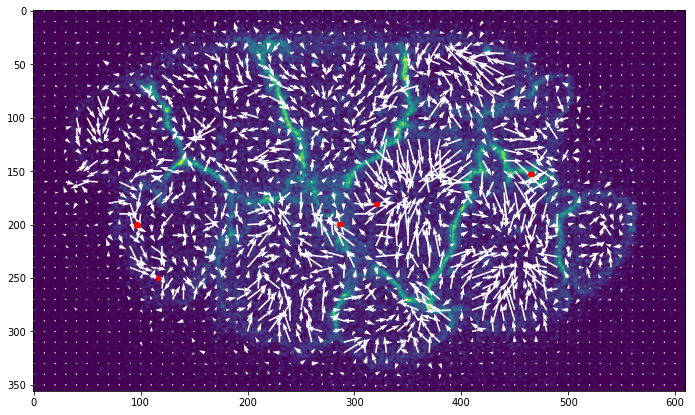

In [68]:
epsilon = 0.1
plot_sinks(avg_flow_x, avg_flow_y, epsilon)

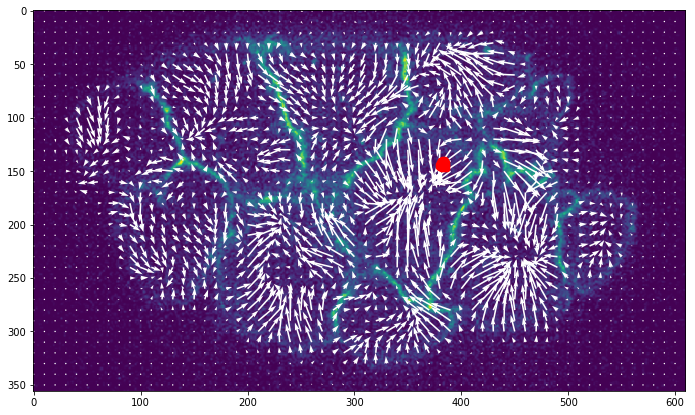

In [69]:
epsilon = .01
plot_sinks(smooth_flow_x, smooth_flow_y, epsilon)

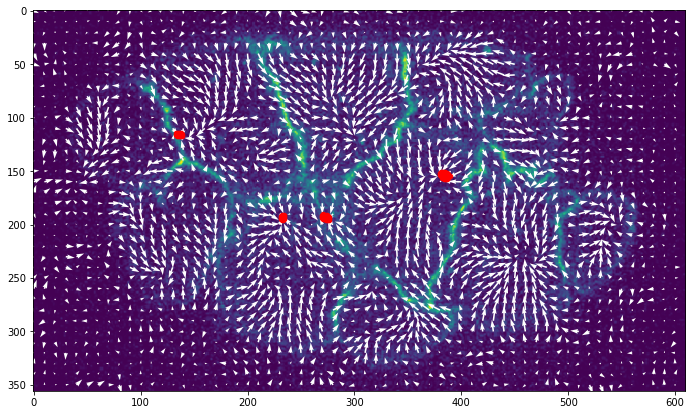

In [70]:
epsilon = .01
plot_sinks(smooth_norm_x, smooth_norm_y, epsilon)